# Visualize connectivity II, asymmetry
In this notebook we aim to visualize how different choies of the time constant for the z traces (post and pre) affect the symmetry of the connectivity matrix. We do to things
* Plot a connectivity matrix for markedly different values of the z traces time constants.
* Quantitfy systematic how far away we go from symmetry as the values of the time costants drift appart from each other.

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from network import BCPNN, NetworkManager
from data_transformer import build_ortogonal_patterns
from analysis_functions import calculate_angle_from_history
from analysis_functions import calculate_winning_pattern_from_distances, calculate_patterns_timings

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

#### Git
As usual if we want to return to the last working simulation of this we acivate this:

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '39de00787555d13af5b9820bebd10f6b56accfc3'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Network building and training
First we build the patterns

In [3]:
hypercolumns = 3
minicolumns = 5
n_patterns = 5  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

First we build a neural network where the time traces have very different dynamics

In [4]:
# Build the network
tau_z_pre = 1.00
tau_z_post = 0.010

nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)

In [5]:
dt = 0.001
T_training = 1.0
training_time = np.arange(0, T_training + dt, dt)
values_to_save = ['o', 'z_pre', 'z_post', 'a']
manager = NetworkManager(nn=nn, time=training_time, values_to_save=values_to_save)


In [6]:
for pattern in patterns:
    nn.k = 1.0
    # history = nn.run_network_simulation(time=training_time, I=pattern, save=True)
    manager.run_network(time=training_time, I=pattern)

w1 = nn.w

Now we build a second network where the z_traces are more similar

In [7]:
# Build the network
tau_z_pre = 0.250
tau_z_post = 0.250

nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)

In [8]:
dt = 0.001
T_training = 1.0
training_time = np.arange(0, T_training + dt, dt)
values_to_save = ['o', 'z_pre', 'z_post', 'a']
manager = NetworkManager(nn=nn, time=training_time, values_to_save=values_to_save)

In [9]:
for pattern in patterns:
    nn.k = 1.0
    # history = nn.run_network_simulation(time=training_time, I=pattern, save=True)
    manager.run_network(time=training_time, I=pattern)

w2 = nn.w

## Plot the matrix

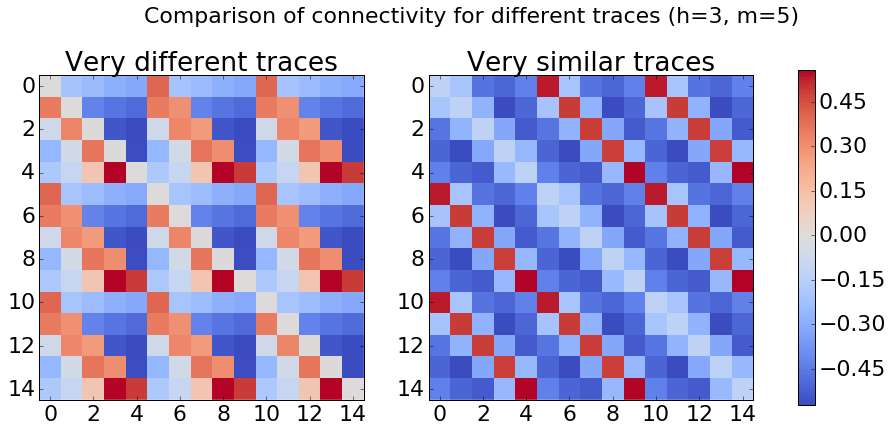

In [10]:
# Plot it
cmap = 'coolwarm'
fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(w1, cmap=cmap, interpolation='None')
ax1.set_title('Very different traces')

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(w2, cmap=cmap, interpolation='None')
ax2.set_title('Very similar traces')

fig.suptitle('Comparison of connectivity for different traces (h=3, m=5)' , y=0.78)

axes = fig.get_axes()
fig.colorbar(im1, ax=axes, shrink=0.50)

plt.show()

We note thatthe matrix with very different traces isassymetric with respect to the contents in the diagonal. In other words, if you look at the diagonal patterns and look around them you will realize that the patterns before the diagonal and after the diagonal are different. This is consistent with 

## Systematic study of the z_traces

In [11]:
# Analysis parameters
norms = []

# Range of the z-traces time constant differences
start = 0.010
step = 0.010
end = 2.0

tau_z_post = 0.500
tau_z_vector = np.arange(start, end + step, step)

In [12]:
for tau_z_pre in tau_z_vector:

    nn = BCPNN(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre)
    nn.randomize_pattern()

    # Build the network manager
    dt = 0.001
    T_training = 1.0
    training_time = np.arange(0, T_training + dt, dt)
    values_to_save = ['o', 'z_pre', 'z_post', 'a']
    manager = NetworkManager(nn=nn, time=training_time, values_to_save=values_to_save)

    for pattern in patterns:
        nn.k = 1.0
        # history = nn.run_network_simulation(time=training_time, I=pattern, save=True)
        manager.run_network(time=training_time, I=pattern)


    w = nn.w
    anty_symm = (w - w.T)
    frobenius = np.linalg.norm(anty_symm)
    norms.append(frobenius)


#### Plot this

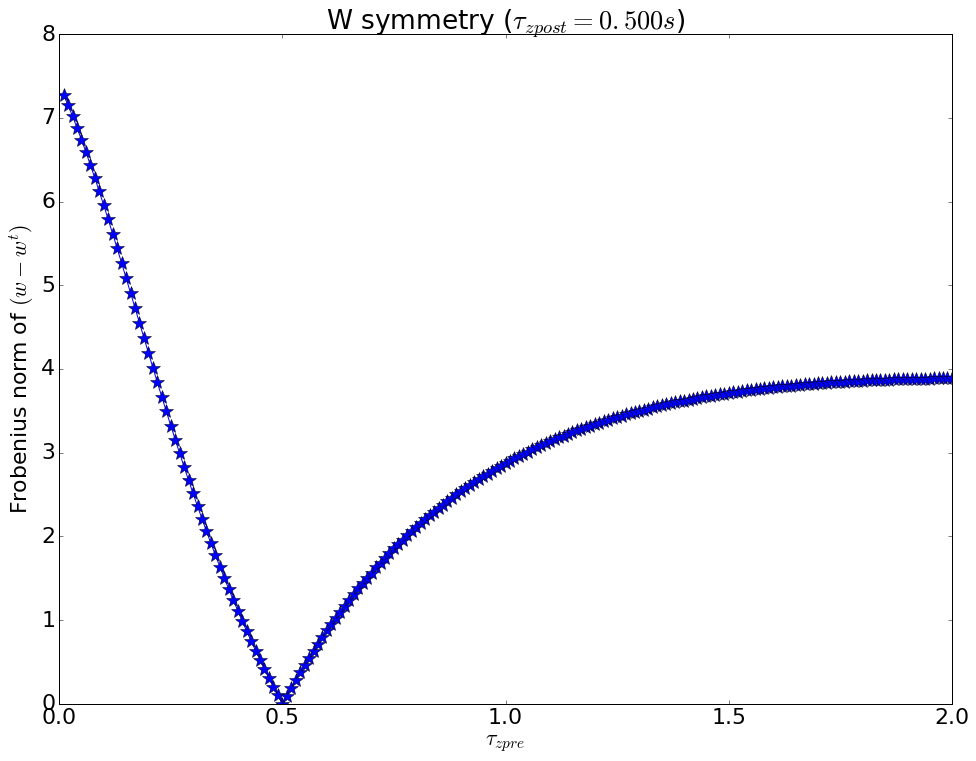

In [13]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

line, = ax.plot(tau_z_vector, norms, '*-', markersize=14)

ax.set_title(r'W symmetry ($\tau_{zpost}=0.500 s$)')
ax.set_xlabel(r'$\tau_{zpre}$')
ax.set_ylabel(r'Frobenius norm of $(w - w^t)$')

plt.show()



#### Git reset

In [14]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])